In [1]:
from jax_circuits import*
from topology import *
from penalty import *
import matplotlib.pyplot as plt
from scipy.stats import unitary_group
from qiskit import transpile
from qiskit.quantum_info import Operator
import pickle

Initially the goal was to try and use CP-gates to learn optimal CZ placements. This seems to be very difficult because of the local minimums. Whether the minimums are related to CP-penaly function or to 1q gate angles is not clear. Several directions can be interesting besides looking for truly optimal CZ decompositions:
- Do CP circuits learn themselves better, compared to CZ circuits at the same gate count?
- Compare non-optimal CZ decompositions with some other transpiling implementation, such as Qiskit.
- Be OK with arbitrary angles in CP gates. Does this perform better? Can this improve on the number of CZ gates in qiskit?
- How is sum of CP angles distributed? Say, if you need 20 CNOT in the circuit, does it mean that CP angles must sum to ~20 *pi , or one can do better?


# Aux

In [2]:
def random_cp_angles(num_angles, cp_mask, cp_dist='0', key=random.PRNGKey(0)):
    """Initialized 1q angles randomly but keeps CP angles zero."""
    key, subkey = random.split(key)
    rnd_angles = random_angles(num_angles, key=subkey)*(1-cp_mask)
    if cp_dist == '0':
        return rnd_angles
    elif cp_dist == 'normal':
        key, subkey = random.split(key)
        return rnd_angles+1.5*random.normal(subkey, shape=(num_angles, ))*cp_mask
    else:
        print('cp_dist', cp_dist, 'not supported')
                                                                                            
def cp_loss_linear(loss_func, angles, cp_mask, reg=1, ymax=2, xmax=jnp.pi/2, plato=0.05):
    """Loss functions combined with linear CP penalty."""
    cp_angles = angles*cp_mask
    penalty_loss = cp_penalty_linear(cp_angles, ymax, xmax, plato).sum()
    return loss_func(angles)+reg*penalty_loss

def cp_loss_L1(loss_func, angles, cp_mask, reg=1):
    """Loss functions combined with L1 CP penalty."""
    cp_angles = angles*cp_mask
    penalty_loss = jnp.abs(cp_angles).sum()
    return loss_func(angles)+reg*penalty_loss

def cz_value(a, threshold=1e-2):
    """Return 0 if CP-angle is near zero, 1 if it is near pi and 2 else."""
    t=threshold
    a = a % (2*jnp.pi)
    return jnp.piecewise(a, 
                         [a < t, jnp.abs(a-2*jnp.pi)<t, jnp.abs(a-jnp.pi)<t],
                         [0, 0, 1, 2])    

def count_cz(angles, threshold=1e-2):
    """Count the number of CZ gate in the circuit, omitting CP gates with angles below the threshold."""
    return sum([cz_value(a, threshold) for a in angles])

def plot_cp_angles(angles, h=2, t=1e-2):
    """Plot all CP angles in the circuit placing them on the cost function profile."""
    a_sweep = jnp.linspace(0, 2*jnp.pi, 200)
    angles = angles % (2*jnp.pi)
    plt.plot(a_sweep, cp_penalty_linear(a_sweep, h, t))
    plt.scatter(angles, 
                cp_penalty_linear(angles, h, t)+0.1*random.normal(random.PRNGKey(0), (len(angles), )), 
                alpha=0.5)
    

def report_cp_learning(res, cp_mask=None):
    """Overview of a single run of CP learning."""
    angles_hist, regloss_hist, loss_hist, reg_hist = res['params'], res['regloss'], res['loss'], res['reg']
    best_angles = angles_hist[jnp.argmin(regloss_hist)]
    
    if cp_mask is not None:
        best_cp_angles = best_angles*cp_mask
        best_cp_angles = best_cp_angles[best_cp_angles!=0]
        print('cz count: {}'.format(count_cz(best_cp_angles, threshold=0.2)))
        print('fidelity at this count: {}'.format(loss_hist[jnp.argmin(loss_hist)]))
    else:
        best_cp_angles = None
        
    plt.plot(regloss_hist, label='regloss')
    plt.plot(loss_hist, label='loss')
    plt.plot(reg_hist, label='reg')
    plt.yscale('log')
    plt.legend()
    
    return best_angles, best_cp_angles

def project_cp_angle(a, threshold=0.2):
    a = a % (2*jnp.pi)
    if jnp.abs(a -jnp.pi)<threshold:
        return jnp.pi
    elif jnp.abs(a)<threshold or jnp.abs(a-2*jnp.pi)<threshold:
        return 0
    else:
        return a
        
def cp_to_cz(anz, angles, threshold=0.2):
    mask = anz.cp_mask
    indices = jnp.where(mask==1)[0]
    cp_angles = angles[mask==1]
    
    
    projected_cp_angles = jnp.array([project_cp_angle(a, threshold) for a in cp_angles])
    projected_mask = (projected_cp_angles==0)+(projected_cp_angles==jnp.pi)
    projected_cp_angles = projected_cp_angles[projected_mask]
    projected_indices = [int(i) for i in indices[projected_mask]]
    
    free_angles = jnp.array([a for i, a in enumerate(angles) if i not in projected_indices])
    
    return [constrained_function(anz.circuit, projected_cp_angles, projected_indices), 
            constrained_function(anz.unitary, projected_cp_angles, projected_indices),
            free_angles]

# 3-qubit Toffoli

## Regularized CP

Here we use regularized CP learning to find optimal CZ compilation.

In [3]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

anz = Ansatz(3, 'cp', fill_layers(sequ_layer(3), 10))
loss_f  = lambda angs: disc2(anz.unitary(angs), u_toff3)

reg_options = {'r': 0.01,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 6,
               'angle_tolerance': 0.4,
               'cp_mask': anz.cp_mask}

Learning from completely random angles. Note: 'sucess' indicator should be treated with care, currently threshold values are very permissive.

In [4]:
n_samples = 5
initial_angles_array = [random_cp_angles(anz.num_angles, anz.cp_mask, cp_dist='normal', key=random.PRNGKey(i)) for i in range(n_samples)]
res = anz.learn(u_toff3, 
#                          regularization_options=reg_options, 
                         initial_angles=initial_angles_array,
                         num_iterations=2000,
                         target_loss=1e-4)

100%|██████████| 5/5 [00:17<00:00,  3.50s/it]


cz count: 13.0
fidelity at this count: 8.380413055419922e-05


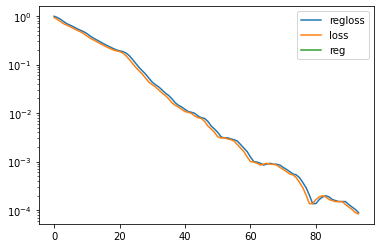

In [5]:
_, _ = report_cp_learning(res[0], anz.cp_mask)

In [6]:
%%time
n_samples = 10
initial_angles_array = [random_cp_angles(anz.num_angles, anz.cp_mask, cp_dist='normal', key=random.PRNGKey(i)) for i in range(n_samples)]
res_history = anz.learn(u_toff3, 
                         regularization_options=reg_options, 
                         initial_angles=initial_angles_array,
                         num_iterations=2000)

  0%|          | 0/10 [00:00<?, ?it/s]

compiling...


100%|██████████| 10/10 [00:31<00:00,  3.12s/it]

CPU times: user 34.5 s, sys: 1.46 s, total: 36 s
Wall time: 32 s


In [32]:
for a in tqdm(jnp.arange(10)):
    pass

100%|██████████| 10/10 [00:00<00:00, 21509.25it/s]


In [28]:
from tqdm import tqdm

cz count: 7.0
fidelity at this count: 0.0005062222480773926


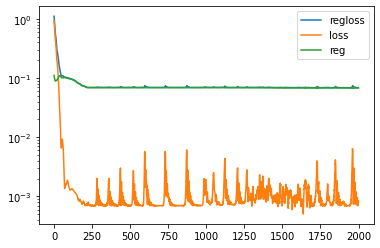

In [23]:
_, _ = report_cp_learning(res_history[0], anz.cp_mask)

## Constrained connectivity

In [ ]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

qc_trans = transpile(qc, basis_gates=['cz', 'rx', 'ry', 'rz'], coupling_map=[[0,1],[1,0],[1,2],[2,1]], optimization_level=3)
print(qc_trans.qasm().count('\ncz'))
qc_trans.draw(output='mpl')

In [ ]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

anz = Ansatz(3, 'cp', fill_layers(chain_layer(3), 18))
loss_f  = lambda angs: disc2(anz.unitary(angs), u_toff3)

reg_options = {'r': 0.001,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 8,
               'angle_tolerance': 0.1,
               'cp_mask': anz.cp_mask}

In [ ]:
%%time
initial_angles_array = [random_angles(anz.num_angles, key=random.PRNGKey(i)) for i in range(40)]
res, best_params, success = anz.learn(u_toff3, 
                         regularization_options=reg_options, 
                         initial_angles=initial_angles_array,
                         target_loss=1e-4)
res_rnd=res, best_params, success

print(sum(success)/len(success))

In [ ]:
%%time
initial_angles_array = [random_cp_angles(anz.num_angles, anz.cp_mask, key=random.PRNGKey(i)) for i in range(40)]
res, best_params, success = anz.learn(u_toff3, 
                         regularization_options=reg_options, 
                         initial_angles=initial_angles_array,
                         target_loss=1e-4)
res_cp=res, best_params, success

print(sum(success)/len(success))

In [ ]:
jnp.where(jnp.array(success)==True)

In [ ]:
_, _ = report_cp_learning(res[8], anz.cp_mask)

In [ ]:
anz.circuit(best_params[8]).draw(output='mpl')

## Unconstrained CP

Learning 3-qubits Toffoli with predefined pattern of 2-qubit gates. Note that the problem is not trivial because without CP gates the learning is about 80% likely to be stuck in local minimum. Let's see if we can do better with CP regularization.

First, unconctrained CP optimization gets the job done very easily and reliably.

In [ ]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

placements_toff3 = [[1, 2], [0, 2], [1, 2], [0, 2], [0, 1], [0, 1]]
anz_toff3 = Ansatz(3, 'cp', placements={'free': placements_toff3})

anz_toff3.circuit().draw(output='mpl')

In [ ]:
%time
res, best_angles, sucess = anz_toff3.learn(u_toff3)
_,_ = report_cp_learning(res)

# Toffoli 4

In [4]:
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data

In [5]:
%%time
anz= Ansatz(4, 'cp', fill_layers(sequ_layer(4), 23))

reg_options = {'r': 0.001,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 14,
               'angle_tolerance': 0.1,
               'cp_mask': anz.cp_mask}

CPU times: user 143 ms, sys: 4.38 ms, total: 147 ms
Wall time: 148 ms


In [6]:
%%time
initial_angles_array = [random_angles(anz.num_angles, key=random.PRNGKey(i)) for i in range(200, 400)]
res, best_params, success = anz.learn(u_toff4, 
                         regularization_options=reg_options, 
                         initial_angles=initial_angles_array,
                         num_iterations=2000,             
                         target_loss=1e-4)
res_rnddd=res, best_params, success
with open('toff4_conn', 'wb') as f:
     pickle.dump(res_rnddd, f)

print(sum(success)/len(success))

0.345
CPU times: user 1h 24min 24s, sys: 26.1 s, total: 1h 24min 50s
Wall time: 1h 22min 1s


In [7]:
jnp.where(jnp.array(success)==True)

(DeviceArray([  1,   2,   4,   5,   8,   9,  12,  14,  15,  16,  17,  19,
               23,  24,  29,  34,  36,  37,  38,  40,  41,  42,  43,  47,
               51,  53,  54,  57,  58,  59,  62,  73,  75,  84,  85,  87,
               89,  91,  97,  99, 104, 106, 107, 108, 112, 115, 118, 125,
              129, 139, 142, 144, 151, 152, 153, 154, 162, 164, 167, 168,
              174, 175, 176, 183, 184, 185, 187, 190, 198], dtype=int32),)

In [29]:
count_cz(best_params[8]*anz.cp_mask, threshold=0.1)

DeviceArray(15., dtype=float32)

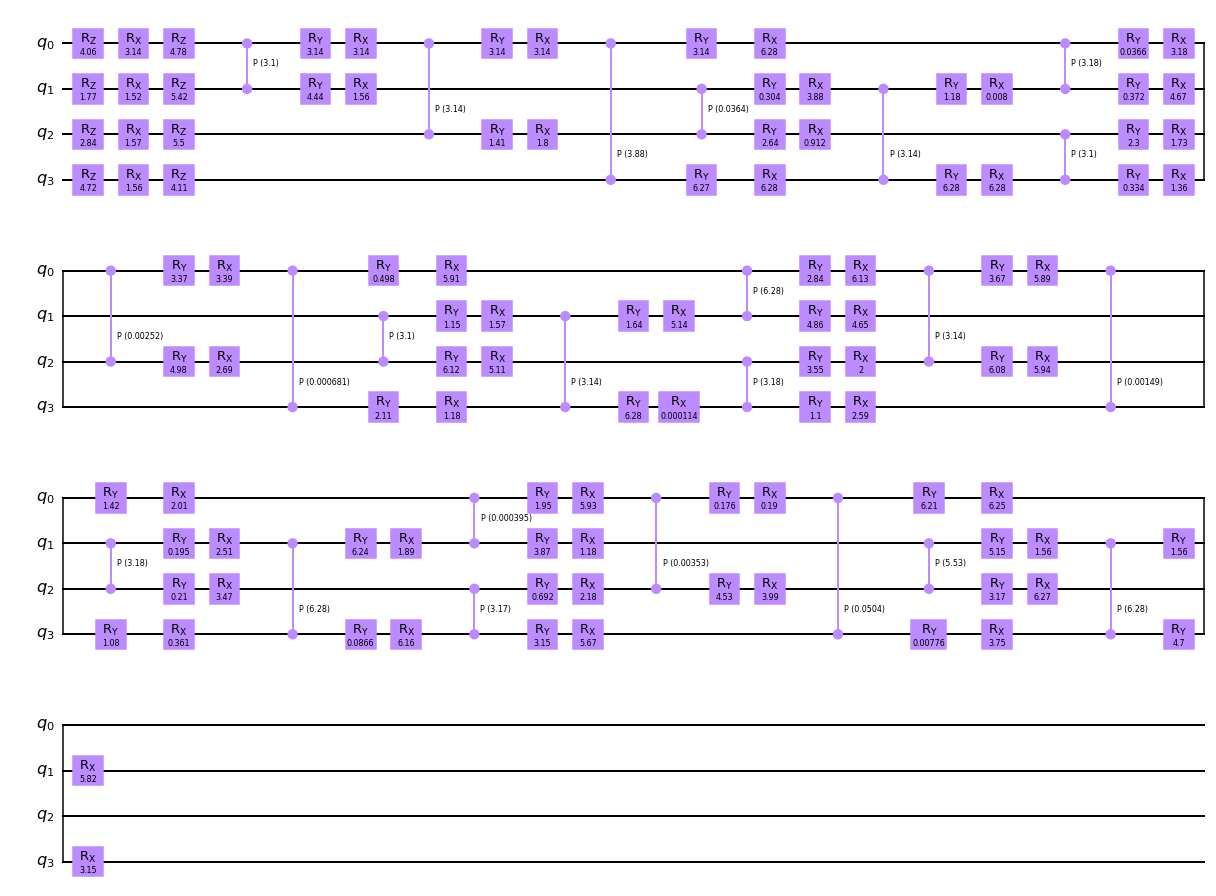

In [27]:
anz.circuit(best_params[8] % (2*jnp.pi)).draw(output='mpl')

cz count: 19.0
fidelity at this count: 5.0902366638183594e-05


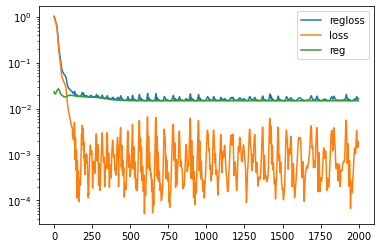

In [20]:
_, _ = report_cp_learning(res[1],cp_mask=anz.cp_mask)

In [104]:
%%time
initial_angles_array = [random_angles(anz.num_angles, key=random.PRNGKey(i)) for i in range(100,200)]
res, best_params, success = anz.learn(u_toff4, 
                         regularization_options=reg_options, 
                         initial_angles=initial_angles_array,
                         target_loss=1e-4)
res_rnd=res, best_params, success

print(sum(success)/len(success))

0.0
CPU times: user 40min 40s, sys: 32.4 s, total: 41min 13s
Wall time: 37min 22s


cz count: 23.0
fidelity at this count: 0.0045503973960876465


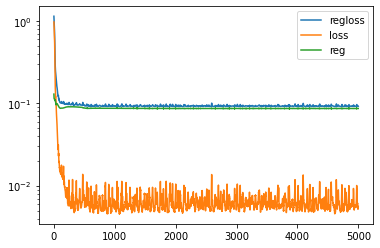

In [112]:
_,_ = report_cp_learning(res[28], anz.cp_mask)

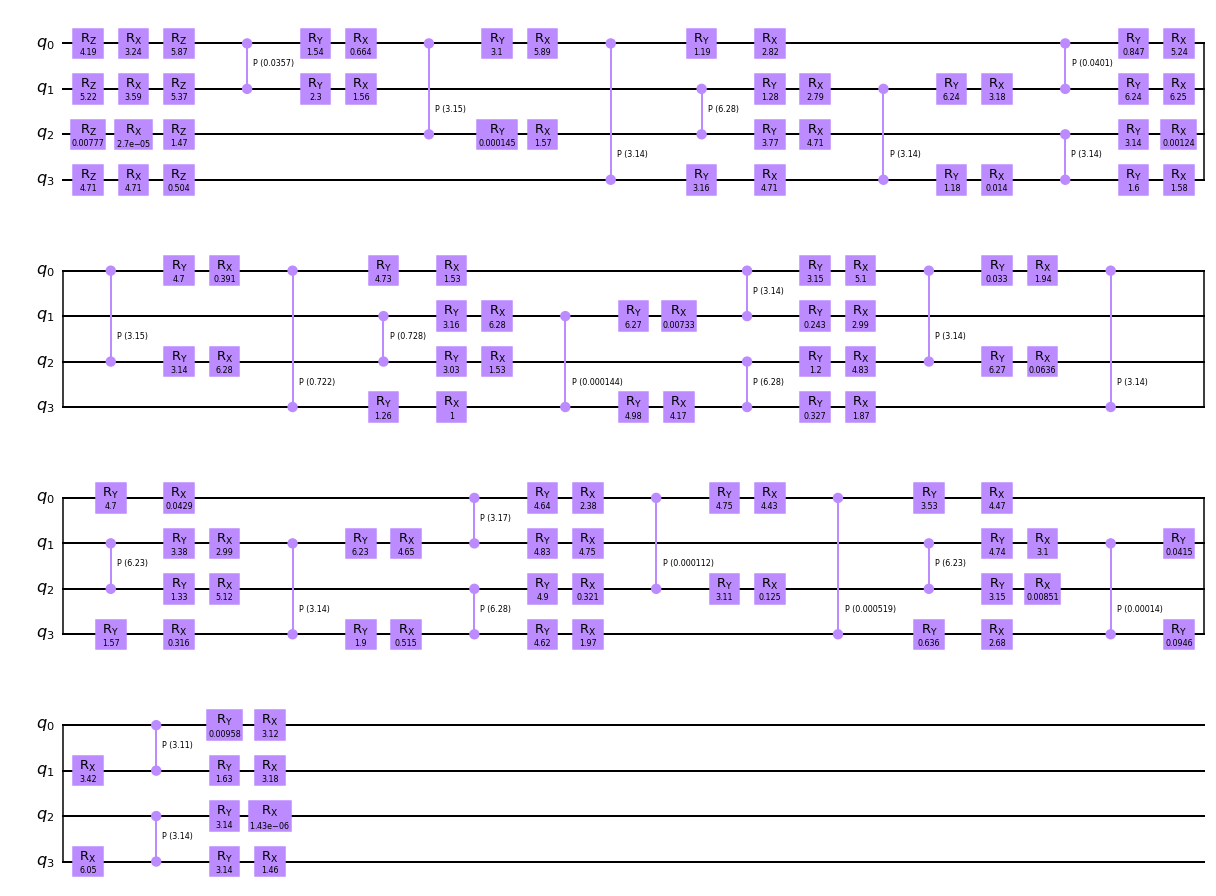

In [91]:
anz.circuit(best_params[63] % (2*jnp.pi)).draw(output='mpl')

## Restricted topology

In [99]:
anz= Ansatz(4, 'cp', fill_layers(chain_layer(4), 30))

reg_options = {'r': 0.001,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 20,
               'angle_tolerance': 0.1,
               'cp_mask': anz.cp_mask}

In [108]:
%%time
initial_angles_array = [random_angles(anz.num_angles, key=random.PRNGKey(i)) for i in range(400)]
res, best_params, success = anz.learn(u_toff4, 
                         regularization_options=reg_options, 
                         initial_angles=initial_angles_array,
                         num_iterations=2000,
                         target_loss=1e-4)

res_rnd=res, best_params, success

print(sum(success)/len(success))

0.005
CPU times: user 1h 13min 40s, sys: 45.8 s, total: 1h 14min 26s
Wall time: 1h 11min 33s


cz count: 21.0
fidelity at this count: 0.03812211751937866


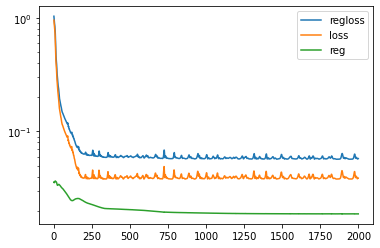

In [109]:
_,_ = report_cp_learning(res[1], anz.cp_mask)

# Learning in the difficult region

In [53]:
%%time
placements = fill_layers(sequ_layer(3), 9)
anz_cz = Ansatz(3, 'cz', placements=placements)
target_angles = random_angles(anz_cz.num_angles, key=random.PRNGKey(1))
u_target = anz_cz.unitary(target_angles)

anz_cp = Ansatz(3, 'cp', placements=placements)
angles_hist, loss_hist, disc_hist, penalty_hist = anz_cp.learn(u_target, 
                                      method='natural adam', 
                                      cp_penalty=True, 
                                      h=2, 
                                      t=0.15)

best_angles = angles_hist[jnp.argmin(loss_hist)]

CPU times: user 47.4 s, sys: 19 s, total: 1min 6s
Wall time: 29.6 s


14.0


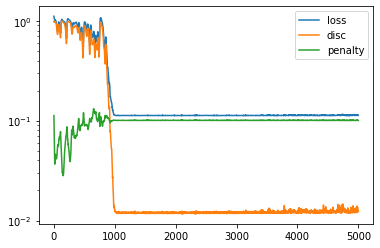

In [54]:
print(count_cnots(best_angles*anz_cp.cp_mask))
plt.plot(loss_hist, label='loss')
plt.plot(disc_hist, label='disc')
plt.plot(penalty_hist, label='penalty')
plt.yscale('log')
plt.legend()

In [55]:
%%time
best_angles_hist, success_hist = success_rate(anz_cp, u_target, 9, 'natural adam', t=t, num_samples=100)

CPU times: user 38min 25s, sys: 6min 54s, total: 45min 20s
Wall time: 31min 38s


In [56]:
sum(success_hist)/len(success_hist)

0.0

In [58]:
%%time
best_angles_hist, success_hist = success_rate(anz_cp, u_target, 9, 'natural gd', t=t, num_samples=100)

CPU times: user 38min 50s, sys: 5min 53s, total: 44min 44s
Wall time: 32min 43s


In [59]:
sum(success_hist)/len(success_hist)

0.0

In [60]:
%%time
best_angles_hist, success_hist = success_rate(anz_cp, u_target, 9, 'adam', t=t, num_samples=100)

CPU times: user 16min 51s, sys: 7.4 s, total: 16min 58s
Wall time: 16min 34s


In [61]:
sum(success_hist)/len(success_hist)

0.0

In [5]:
%%time
placements = fill_layers(sequ_layer(3), 8)
anz_cz = Ansatz(3, 'cz', placements=placements)
target_angles = random_angles(anz_cz.num_angles, key=random.PRNGKey(1))
u_target = anz_cz.unitary(target_angles)

t=0.15
anz_cp = Ansatz(3, 'cp', placements=fill_layers(sequ_layer(3), 10))

CPU times: user 841 ms, sys: 5.87 ms, total: 846 ms
Wall time: 835 ms


In [6]:
%%time
best_angles_hist, success_hist = success_rate(anz_cp, u_target, 10, 'adam', t=t, num_samples=50)

CPU times: user 9min 5s, sys: 3.9 s, total: 9min 9s
Wall time: 8min 56s


In [7]:
sum(success_hist)

0

Not successfull yet.

# Learning with extra gates

Works fine for toffoli 3.

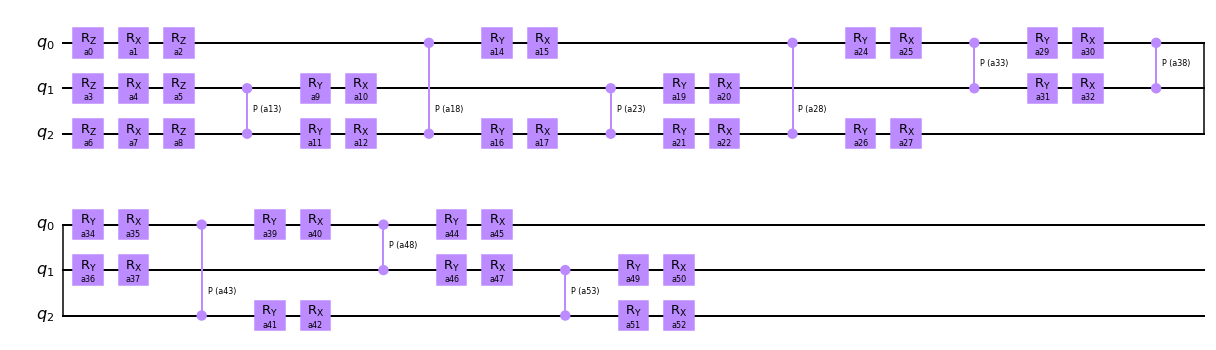

In [8]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

placements_toff3 = [[1, 2], [0, 2], [1, 2], [0, 2], [0, 1], [0, 1]]
extra_placements = [[0, 2], [0, 1], [1, 2]]

anz_toff3 = Ansatz(3, 'cp', placements={'free': placements_toff3+extra_placements})

anz_toff3.circuit().draw(output='mpl')

In [83]:
%%time
initial_angles = random_cp_angles(anz_toff3.num_angles, anz_toff3.cp_mask, key=random.PRNGKey(10))
res = anz_toff3.learn(u_toff3, method='natural adam', cp_penalty=True, t=0.15, learning_rate=0.025, r=0.0005, initial_params=initial_angles)
angs_hist, loss_hist, disc_hist, penalty_hist = res

CPU times: user 1min 1s, sys: 21.1 s, total: 1min 22s
Wall time: 41.6 s


cnot count: 6.0
fidelity at this count: 8.821487426757812e-06


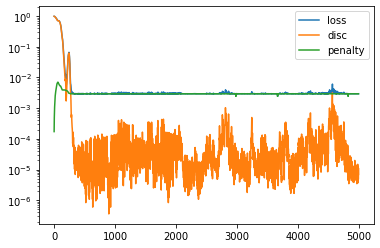

In [84]:
best_angles, best_cp_angles = report_cp_learning(res, cp_mask=anz_toff3.cp_mask)

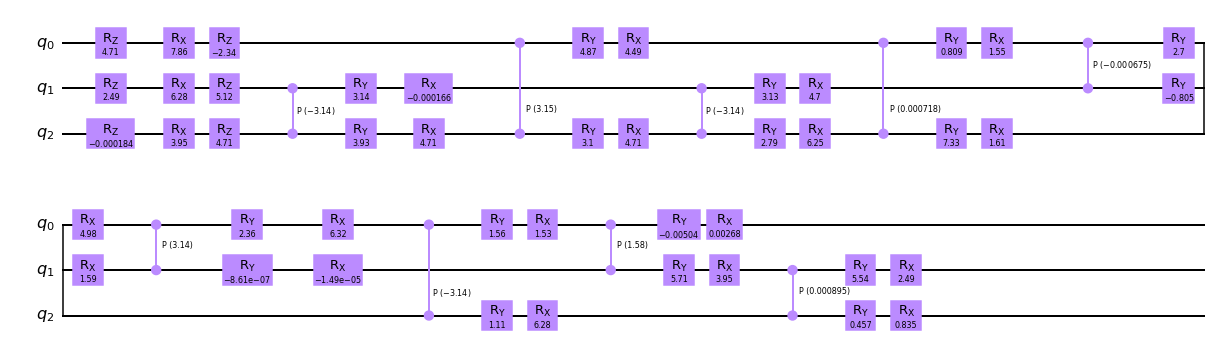

In [68]:
anz_toff3.circuit(best_angles).draw(output='mpl')

In [3]:
anz_cz = Ansatz(3, 'cz', placements=fill_layers(sequ_layer(3), 8))
angles_target = random_angles(anz_cz.num_angles, key=random.PRNGKey(123))
u_target = anz_cz.unitary(angles_target)

anz_cp = Ansatz(3, 'cp', placements=fill_layers(sequ_layer(3), 14))

cnot count: 18.0
fidelity at this count: 0.005213022232055664
CPU times: user 17.4 s, sys: 346 ms, total: 17.8 s
Wall time: 16.3 s


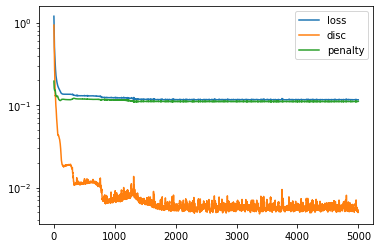

In [43]:
%%time
initial_angles = random_cp_angles(anz_cp.num_angles, anz_cp.cp_mask, key=random.PRNGKey(2))
initial_angles = initial_angles+jnp.pi*jnp.ones(len(initial_angles))*anz_cp.cp_mask
initial_angles = random_angles(anz_cp.num_angles, key=random.PRNGKey(2))

res = anz_cp.learn(u_target, 
                   method='adam', 
                   cp_penalty=True, 
                   xmax=1.5, 
                   ymax=2,
                   plato=0.01,
                   learning_rate=0.1, 
                   r=0.01, 
                   initial_params=initial_angles, 
                   num_iterations=5000)

angs_hist, loss_hist, disc_hist, penalty_hist = res
best_angles, best_cp_angles = report_cp_learning(res, cp_mask=anz_cp.cp_mask)

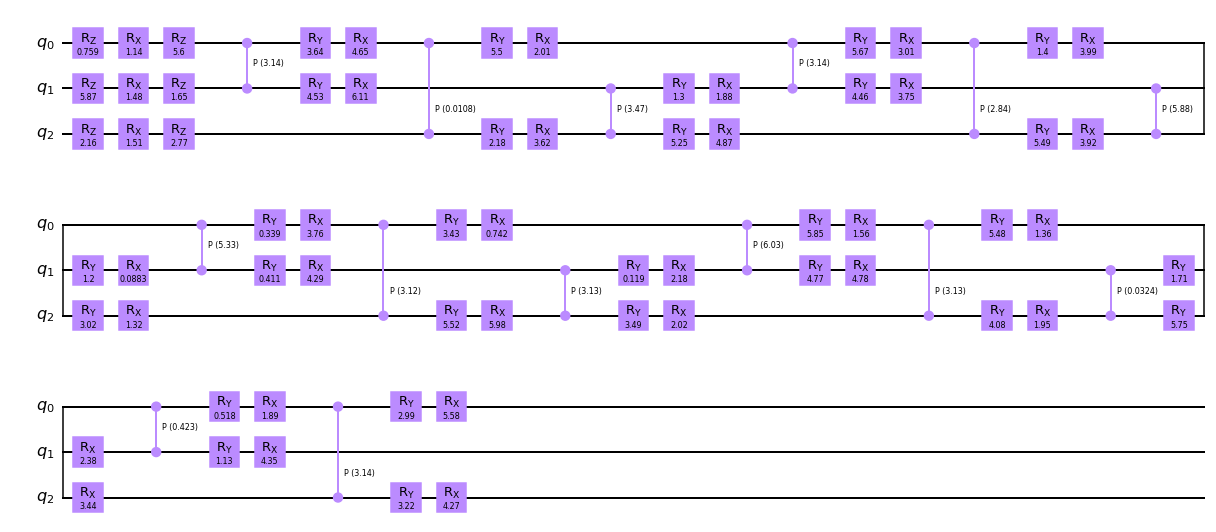

In [44]:
anz_cp.circuit(best_angles % (2*jnp.pi)).draw(output='mpl')

In [45]:
anz_3 = Ansatz(3, 'cz', placements=fill_layers(sequ_layer(3), 10))
ah, lh = anz_3.learn(u_target)

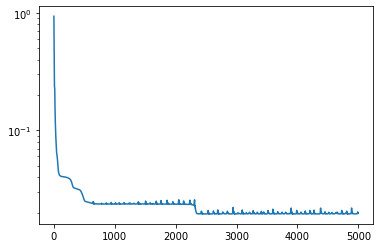

In [38]:
plt.plot(lh)
plt.yscale('log')

# CP circuits learn themselves

Small-scale experiments below suggest that CP circuits are less prone to getting stuck in local minima than CZ circuits of the same gate count. The experiments are for randomly initialized CP angles so the 'effective cz count' of the circuit may be lower than of the corresponding CZ circuits. This will be tested later.

In [22]:
%%time 
key = random.PRNGKey(134)
num_qubits = 3 
num_repeats = 10

gate_counts = list(range(15))[::2]
success_rates = []
for num_gates in gate_counts:
    anz = Ansatz(num_qubits, 'cp', placements=fill_layers(sequ_layer(num_qubits), num_gates))
    key, subkey = random.split(key)
    target_angles = random_angles(anz.num_angles, key=subkey)
    target_u = anz.unitary(target_angles)
    ah, lh, sh = unitary_learn_repeat(anz.unitary, 
                                  target_u, 
                                  anz.num_angles, 
                                  'adam', 
                                  0.1,
                                  num_repeats=num_repeats,
                                  target_loss=1e-4)
    
    success_rates.append(sum(sh)/len(sh))

with open('success_rates_3cp.pickle', 'wb') as f:
     pickle.dump(success_rates, f)

CPU times: user 9min 36s, sys: 9.35 s, total: 9min 45s
Wall time: 9min 14s


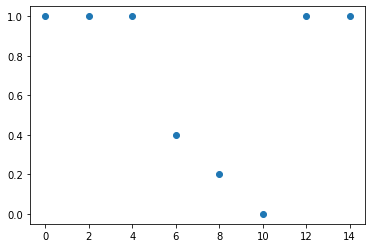

In [23]:
with open('success_rates_3cp.pickle', 'rb') as f:
     success_rates = pickle.load(f)
        
plt.scatter(gate_counts, success_rates)

Let's look at a difficult point in the middle region.

In [25]:
%%time 
key = random.PRNGKey(134)
num_qubits = 3 
num_repeats = 50
num_gates = 9

anz = Ansatz(num_qubits, 'cp', placements=fill_layers(sequ_layer(num_qubits), num_gates))
key, subkey = random.split(key)
target_angles = random_angles(anz.num_angles, key=subkey)
target_u = anz.unitary(target_angles)
ah, lh, sh = unitary_learn_repeat(anz.unitary, 
                                  target_u, 
                                  anz.num_angles, 
                                  'adam', 
                                  0.1,
                                  num_repeats=num_repeats,
                                  target_loss=1e-4)
print(sum(sh)/len(sh))    

0.02
CPU times: user 9min 10s, sys: 15 s, total: 9min 25s
Wall time: 8min 32s


Now let us make a different comparison -- instead of learning CP circuits with random values of CP-angles we will fix all CP gates to be CZ gates in the target circuits. This will give a more honest comparison with the difficulty of learning with CZ circuits.

In [32]:
%%time 
key = random.PRNGKey(134)
num_qubits = 3 
num_repeats = 10

gate_counts = list(range(15))[::2]
success_rates = []
for num_gates in gate_counts:
    anz = Ansatz(num_qubits, 'cp', placements=fill_layers(sequ_layer(num_qubits), num_gates))
    key, subkey = random.split(key)
    target_angles = random_cp_angles(anz.num_angles, anz.cp_mask, key=subkey)+jnp.pi*jnp.ones(anz.num_angles)*anz.cp_mask
    target_u = anz.unitary(target_angles)
    ah, lh, sh = unitary_learn_repeat(anz.unitary, 
                                  target_u, 
                                  anz.num_angles, 
                                  'adam', 
                                  0.1,
                                  num_repeats=num_repeats,
                                  target_loss=1e-4)
    
    success_rates.append(sum(sh)/len(sh))

with open('success_rates_3cp_cz.pickle', 'wb') as f:
     pickle.dump(success_rates, f)

CPU times: user 10min 33s, sys: 11.6 s, total: 10min 45s
Wall time: 10min 15s


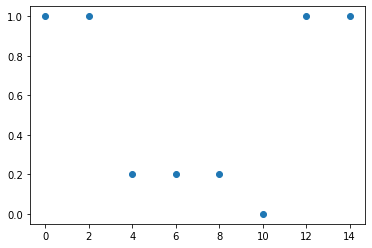

In [33]:
with open('success_rates_3cp_cz.pickle', 'rb') as f:
     success_rates = pickle.load(f)
        
plt.scatter(gate_counts, success_rates)

Again, let's look at the middle region.

In [34]:
%%time 
key = random.PRNGKey(134)
num_qubits = 3 
num_repeats = 50
num_gates = 9

anz = Ansatz(num_qubits, 'cp', placements=fill_layers(sequ_layer(num_qubits), num_gates))
key, subkey = random.split(key)
target_angles = random_cp_angles(anz.num_angles, anz.cp_mask, key=subkey)+jnp.pi*jnp.ones(anz.num_angles)*anz.cp_mask
target_u = anz.unitary(target_angles)
ah, lh, sh = unitary_learn_repeat(anz.unitary, 
                                  target_u, 
                                  anz.num_angles, 
                                  'adam', 
                                  0.1,
                                  num_repeats=num_repeats,
                                  target_loss=1e-4)
print(sum(sh)/len(sh))    

0.0
CPU times: user 9min 44s, sys: 15.5 s, total: 10min
Wall time: 9min 7s


It appears that CP gates do not significantly improve the chance of escaping the local minima even for 3-qubit gates.